In [1]:
!pip install /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
#!pip install https://github.com/WinVector/pyvtreat/raw/master/pkg/dist/vtreat-0.1.tar.gz

Processing /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
  Stored in directory: /Users/johnmount/Library/Caches/pip/wheels/cf/06/fc/6b2552717486fb6401f19308eec24381555e456e3bd9cfb103
Successfully built vtreat
  Found existing installation: vtreat 0.1
    Uninstalling vtreat-0.1:
      Successfully uninstalled vtreat-0.1


In [2]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re

In [3]:
n_rows = 2000
n_signal_variables = 2
n_noise_variables = 2
n_levels = 500

In [4]:
d = pandas.DataFrame({"y":numpy.random.normal(size = n_rows)})

In [5]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.normal(size=1)[0]
    return values

In [6]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [7]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [8]:
d.head()

,y,var_0,var_1,noise_0,noise_1
0,-2.548797,level_159,level_177,level_489,level_303
1,1.334410,level_336,level_200,level_392,level_141
2,1.590087,level_210,level_470,level_180,level_330
3,2.911341,level_172,level_320,level_64,level_89
4,-2.672216,level_190,level_429,level_281,level_353


In [9]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [10]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [11]:
plan = vtreat.NumericOutcomeTreatment()

In [12]:
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train = plan.transform(d_train)

In [13]:
cross_frame.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,0.000000,1.344846,0.001041,-1.122818,0.383464,0.004162,0.000000,0.000000,0.001041,-0.468374,0.870016,0.003122
1,0.000000,1.430466,0.002081,0.843584,0.678714,0.003122,-1.010170,1.440723,0.002081,-0.351811,3.028523,0.005203
2,1.946166,0.375901,0.004162,0.000000,0.000000,0.001041,0.000000,0.000000,0.000000,-1.543429,0.843965,0.003122
3,-1.390406,0.596031,0.002081,-0.780906,1.540433,0.003122,0.995805,0.175595,0.003122,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,2.097130,0.194798,0.003122,-0.486944,0.251367,0.002081,-0.621890,0.996150,0.006243


In [14]:
naive_train.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,-0.736915,1.513576,0.001041,-1.525606,0.743728,0.004162,-1.311637e+00,0.915510,0.001041,-1.803563e-02,2.720060,0.003122
1,1.067410,1.072717,0.002081,1.384065,0.882333,0.003122,-3.457440e-01,2.344432,0.002081,-4.159584e-01,2.209583,0.005203
2,1.799475,0.776463,0.004162,0.452405,2.016736,0.001041,6.938894e-18,1.629639,0.000000,-2.654234e-01,2.431578,0.003122
3,-1.750586,0.765126,0.002081,-1.153223,1.468844,0.003122,3.861209e-02,1.869226,0.003122,-6.938894e-18,1.678575,0.000000
4,0.000000,1.422245,0.000000,0.708788,1.801927,0.003122,-7.716940e-01,0.637664,0.002081,-3.206823e-01,1.214945,0.006243


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_correlation"] = [ 
    scipy.stats.pearsonr(naive_train[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.653123,0.282017,0.216036,False
1,var_1_impact_code,0.666014,0.241603,0.338897,False
2,noise_0_impact_code,0.507148,-0.019908,-0.035445,True
3,noise_1_impact_code,0.509628,0.007864,0.017483,True


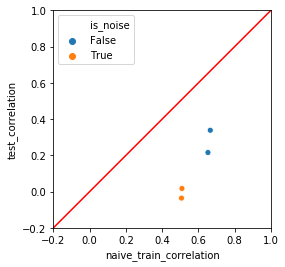

In [16]:
seaborn.scatterplot(x = "naive_train_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

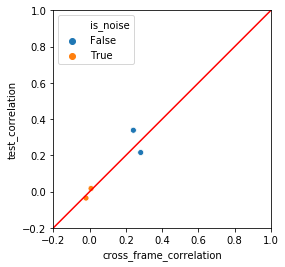

In [17]:
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [18]:
plan.score_frame_.tail()

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
7,noise_0_deviance_code,deviance_code,True,-0.013892,0.667109,4.0,False
8,noise_0_prevalence_code,prevalance,False,-0.013973,0.665300,4.0,False
9,noise_1_impact_code,impact_code,True,0.007864,0.807636,4.0,False
10,noise_1_deviance_code,deviance_code,True,-0.013382,0.678634,4.0,False
11,noise_1_prevalence_code,prevalance,False,-0.029767,0.356645,4.0,False


In [19]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code', 'var_1_impact_code']

In [20]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [21]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [22]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [23]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [24]:
fitter.fit(naive_train[all_vars], y_train)
plot_train["predict_naive_all_vars"] = fitter.predict(naive_train[all_vars])
plot_test["predict_naive_all_vars"] = fitter.predict(prepared_test[all_vars])

In [25]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_all_vars
0,1.334410,-0.262284,-0.166001,0.481449
1,-3.974990,-0.839994,-1.007627,-1.193472
2,-0.115544,0.932904,1.265828,1.215624
3,-3.652621,-0.558218,-0.414215,-0.466489
4,0.783514,-0.361971,-0.451931,-0.265098


In [26]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

0.9192592375026406


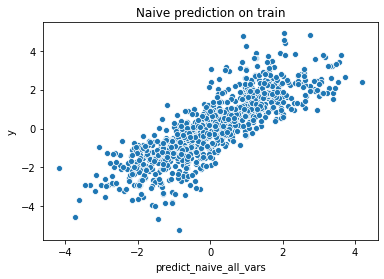

In [27]:
print(rmse(plot_train["predict_naive_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive prediction on train")

1.5546555793625592


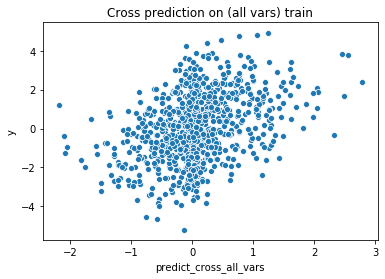

In [28]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

1.5590884903252393


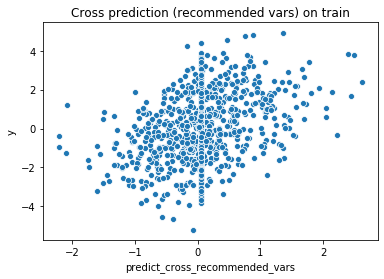

In [29]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

1.671214863449803



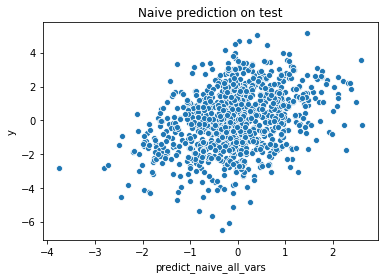

In [30]:
print(rmse(plot_test["predict_naive_all_vars"], plot_test["y"]))
print()
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive prediction on test")

1.6247536210764522


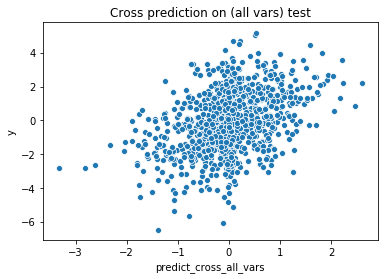

In [31]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

1.6260071980195299


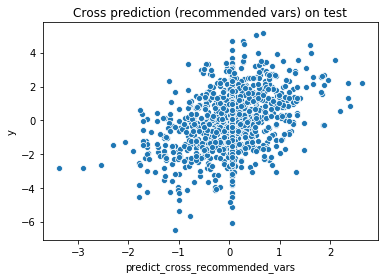

In [32]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [33]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     183.7
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          1.46e-237
Time:                        10:22:33   Log-Likelihood:                -1282.7
No. Observations:                 961   AIC:                             2591.
Df Residuals:                     948   BIC:                             2655.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0783      0.135     -0.579      0.563      -0.344       0.187
var_0_impact_code           0.7125      0.039     18.447      0.000       0.637       0.788
var_0_deviance_code        -0.0040      0.050     -0.079      0.937      -0.102       0.095
var_0_prevalence_code      31.8932     21.767      1.465      0.143     -10.824      74.610
var_1_impact_code           0.7500      0.040     18.639      0.000       0.671       0.829
var_1_deviance_code         0.0264      0.046      0.573      0.567      -0.064       0.117
var_1_prevalence_code      35.5905     22.274      1.598      0.110      -8.121      79.302
noise_0_impact_code         0.5033      0.054      9.295      0.000       0.397       0.610
noise_0_deviance_code      -0.0347      0.042     -0.819      0.413      -0.118       0.049
noise_0_prevalence_code    23.9731     22.060      1.087      0.277     -19.319      67.265
noise_1_impact_code         0.5423      0.053     10.249      0.000       0.438       0.646
noise_1_deviance_code       0.0011      0.040      0.027      0.978      -0.078       0.080
noise_1_prevalence_code    -2.6071     19.724     -0.132      0.895     -41.316      36.102
==============================================================================
Omnibus:                       31.531   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.211
Skew:                           0.032   Prob(JB):                     1.04e-17
Kurtosis:                       4.396   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     12.86
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           1.07e-24
Time:                        10:22:33   Log-Likelihood:                -1787.6
No. Observations:                 961   AIC:                             3601.
Df Residuals:                     948   BIC:                             3665.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0937      0.178      0.525      0.599      -0.256       0.444
var_0_impact_code           0.7070      0.078      9.059      0.000       0.554       0.860
var_0_deviance_code         0.0527      0.077      0.680      0.497      -0.099       0.205
var_0_prevalence_code     -15.3144     40.180     -0.381      0.703     -94.167      63.539
var_1_impact_code           0.6373      0.081      7.876      0.000       0.478       0.796
var_1_deviance_code        -0.0639      0.073     -0.876      0.381      -0.207       0.079
var_1_prevalence_code      70.5571     39.676      1.778      0.076      -7.305     148.419
noise_0_impact_code        -0.0362      0.109     -0.332      0.740      -0.250       0.178
noise_0_deviance_code      -0.0424      0.064     -0.658      0.511      -0.169       0.084
noise_0_prevalence_code     6.7957     41.433      0.164      0.870     -74.515      88.107
noise_1_impact_code        -0.0080      0.106     -0.075      0.940      -0.216       0.200
noise_1_deviance_code      -0.0090      0.062     -0.144      0.886      -0.131       0.113
noise_1_prevalence_code   -36.5205     36.066     -1.013      0.312    -107.299      34.258
==============================================================================
Omnibus:                        4.129   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.316
Skew:                          -0.009   Prob(JB):                        0.191
Kurtosis:                       2.713   Cond. No.                     2.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""